# Assist Networks

Boxscores tally the assists that each player has, but such a representation provides a singular view into a statistic that is dependent on two parties. While assists are already a simplification of creating scoring opportunities through passes and movement, analyzing assists by considering both the assisting and receiving parties allows one to explore offensive relationships within a team.

Section 3.4 in [Basketball Data Science with Applications in R](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=) (BDS) considers such an analysis through assist networks. Assist networks are data visualizations that represent players as nodes and assists from one player to another as edges of a graphical network. Previously, I have considered the construction of assist networks with NBA and WNBA data [here](https://github.com/basketballrelativity/assist_networks), but this notebook adds some bells and whistles to the assist networks inspired by the work in BDS.

The following explores the `PlayByPlay` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `playbyplayv2` endpoints of the [stats.nba.com](https://stats.nba.com).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import playbyplay

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `PlayByPlay` class requires just one parameter:
- `game_id`: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 game between the 76ers and the Pistons.

In [2]:
game_id = '0021900445'
plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

play_df = pd.DataFrame(plays.data['PlayByPlay'])
play_df.head(35)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0021900445,2,12,0,1,7:12 PM,12:00,None,None,None,...,None,None,0,0,None,NaN,None,None,None,0
1,0021900445,4,10,0,1,7:12 PM,12:00,Jump Ball Maker vs. Embiid: Tip to Simmons,None,None,...,76ers,PHI,5,1627732,Ben Simmons,1.610613e+09,Philadelphia,76ers,PHI,1
2,0021900445,7,1,1,1,7:12 PM,11:48,None,None,Harris 8' Jump Shot (2 PTS) (Embiid 1 AST),...,76ers,PHI,0,0,None,NaN,None,None,None,1
3,0021900445,8,2,1,1,7:13 PM,11:27,MISS Maker 9' Jump Shot,None,None,...,None,None,0,0,None,NaN,None,None,None,1
4,0021900445,9,4,0,1,7:13 PM,11:26,Maker REBOUND (Off:1 Def:0),None,None,...,None,None,0,0,None,NaN,None,None,None,1
5,0021900445,10,6,2,1,7:13 PM,11:26,None,None,Harris S.FOUL (P1.T1) (E.Malloy),...,Pistons,DET,1,0,None,NaN,None,None,None,1
6,0021900445,12,3,11,1,7:13 PM,11:26,Maker Free Throw 1 of 2 (1 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
7,0021900445,13,3,12,1,7:13 PM,11:26,Maker Free Throw 2 of 2 (2 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
8,0021900445,15,2,47,1,7:14 PM,11:02,None,None,MISS Horford 13' Turnaround Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
9,0021900445,16,4,0,1,7:14 PM,11:00,None,None,Simmons REBOUND (Off:1 Def:0),...,None,None,0,0,None,NaN,None,None,None,1


In [3]:
play_df.iloc[18]

GAME_ID                                                          0021900445
EVENTNUM                                                                 28
EVENTMSGTYPE                                                              1
EVENTMSGACTIONTYPE                                                        6
PERIOD                                                                    1
WCTIMESTRING                                                        7:15 PM
PCTIMESTRING                                                           9:56
HOMEDESCRIPTION              Maker 3' Driving Layup (4 PTS) (Frazier 1 AST)
NEUTRALDESCRIPTION                                                     None
VISITORDESCRIPTION                                                     None
SCORE                                                                 2 - 4
SCOREMARGIN                                                               2
PERSON1TYPE                                                               4
PLAYER1_ID  

By examining the above play, which includes an assisted basket, we see that the player credited with the assist is included in the play-by-play data through the `PLAYER2` fields. In fact, the following criteria must be met for a row in the play-by-play data to be an assisted basket:
- `EVENTMSGTYPE = 1`: This team event type corresponds to a made basket
- `PLAYER2_ID IS NOT NULL`: Because `PLAYER2_ID` is always the assisting player, this can't be `NULL` for an assisted basket
- `PLAYER1_ID != 0` and `PLAYER2_ID != 0`: Sometimes, an ID referring to nobody is coded as `0`

To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node (scoring player). The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [4]:
def network_data(pbp_df, team_id):
    """ network_data creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data
    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player IDs
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player IDs
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player IDs
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    assist_df = pbp_df[(pbp_df['PLAYER1_TEAM_ID'] == team_id)
                       & (pbp_df['EVENTMSGTYPE'] == 1)
                       & (pd.notnull(pbp_df['PLAYER2_ID']))
                       & (pbp_df['PLAYER1_ID'] != 0)
                       & (pbp_df['PLAYER2_ID'] != 0)]
    unique_players = list(set(list(assist_df['PLAYER1_ID']) + list(assist_df['PLAYER2_ID'])))
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['PLAYER2_ID'], assist_df['PLAYER1_ID'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}

    # This loops through all unique assist tandems and records the
    # source (assisting player), target (scoring player), and
    # weight (number of assists from source to target)
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

For this game, let's construct the assist network for the 76ers (`TEAM_ID = 1610612755`). Ben Simmons recorded an absurd 17 assists on this night, so the network will be interesting!

In [5]:
team_id = 1610612755
nodes, edges, positions, weights = network_data(play_df, team_id)

Instead of just plotting unintelligible team and player IDs, the following pulls team and player names to plot on the assist network for readability.

In [6]:
team_df = play_df[(play_df['PLAYER1_TEAM_ID']==team_id)
                  & (play_df['EVENTMSGTYPE'] == 1)
                  & (pd.notnull(play_df['PLAYER2_ID']))
                  & (play_df['PLAYER1_ID'] != 0)
                  & (play_df['PLAYER2_ID'] != 0)]
team_name = team_df['PLAYER1_TEAM_NICKNAME'].iloc[0]

# Storing player names in the players dictionary
players = {}
unique_scorers = list(set(team_df['PLAYER1_ID']))
for player in unique_scorers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER1_ID']==player]['PLAYER1_NAME'].iloc[0]

unique_passers = list(set(team_df['PLAYER2_ID']))
for player in unique_passers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER2_ID']==player]['PLAYER2_NAME'].iloc[0]

Finally, all of the building blocks gathered above will be used to construct the assist network in the following `plot_network` function.

In [7]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player IDs
        corresponding to players on the team given
    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)
    @param positions (dict): Dictionary with keys of player IDs
         with (x, y) values corresponding to node coordinates
    @param weights (dict): Dictionary with keys of player IDs
        with assists as values
    @param players (dict): Dictionary keyed by player IDs with their names
        as values
    @param team (str): Team name

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    # Initialize the network
    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(team + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])

        # Plotting the node
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[pos] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.003*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.0325*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)

        # With all of the necessary perturbations, the player's name and assist
        # total is plotted along the corresponding node
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.25 to account for instances
    # when a pair of players have edges that overlap.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        # Assisting player
        start_x = positions[node1][0]
        start_y = positions[node1][1]

        # Scoring player
        end_x = positions[node2][0]
        end_y = positions[node2][1]

        axis.annotate("",
            xytext=(start_x, start_y), xycoords='data',
            xy=(end_x, end_y), textcoords='data',
            size=15*assists,
            va='center',
            ha='center',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle='arc3,rad=-0.2',
                            alpha=0.25),
            )

    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [8]:
network = plot_network(nodes, edges, positions, weights, players, team_name)

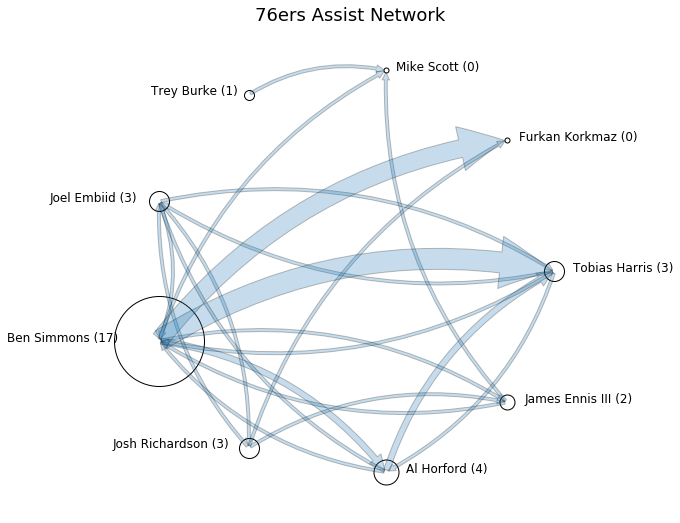

In [9]:
network

Pretty cool! A few things immediately jump out when observing this network.
- Ben Simmons concentrated most of his assists to two players: 6 assists to Furkan Korkmaz and 7 assists to Tobias Harris. Korkmaz finished with 26 points and Harris finished with 22 points
- Two players failed to record an assist for the 76ers
- No 76er really came close to Simmons, with the next closest player (Al Horford) recording 4 assists

## Conclusion

This notebook provides the foundation to produce assist networks for NBA teams at the game level. The above is detailed in the Section 3.4 of Chapter 3 in [A Starting Point for Analyzing Basketball Statistics](https://statsbylopez.files.wordpress.com/2016/01/jqas-2007-3-3-1070.pdf) and BDS provides additional features such as looking at assist networks on the season-level and adding more aesthetics to the networks.

Feel free to explore the above by visualizing different teams or enhancing the assist networks!